# Laboratory: Natural Language Processing (NLP)

**Topic:** Sentiment Analysis and Named Entity Recognition (NER) using spaCy.

**Educational Objectives:** Understanding the text processing pipeline, dimensionality reduction techniques (TF-IDF), interpretability of linear models, and semantic information extraction (NER).

---

## 1. Environment Setup and Libraries

Unlike older approaches based on NLTK, we will use the **spaCy** library, which offers efficient lemmatization implementations and pre-trained language models. **Scikit-learn** will be used for matrix calculations and statistical modeling.



In [1]:
# Install dependencies (uncomment if necessary)
# !pip install spacy pandas scikit-learn matplotlib seaborn wordcloud
# !python -m spacy download en_core_web_sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the spaCy model
# We disable the 'parser' (syntactic dependencies) to speed up preprocessing for classification tasks
nlp = spacy.load('en_core_web_sm')


## 2. Data Engineering and Exploratory Data Analysis (EDA)

The IMDB dataset contains 50,000 movie reviews labeled simply as positive or negative. Due to the computational complexity of NLP operations (specifically NER), this laboratory operates on a representative sample.

In [2]:
# Load data
df = pd.read_csv('IMDB Dataset.csv')

# Sample 2000 rows with a random state for reproducibility
df = df.sample(n=2000, random_state=42).reset_index(drop=True)

# Verify class balance
print(df['sentiment'].value_counts(normalize=True))

sentiment
negative    0.512
positive    0.488
Name: proportion, dtype: float64


### 2.1 Corpus Visualization (WordCloud)
Analyzing word frequency in raw text allows for a preliminary assessment of information noise (e.g., HTML tags, common stop words).

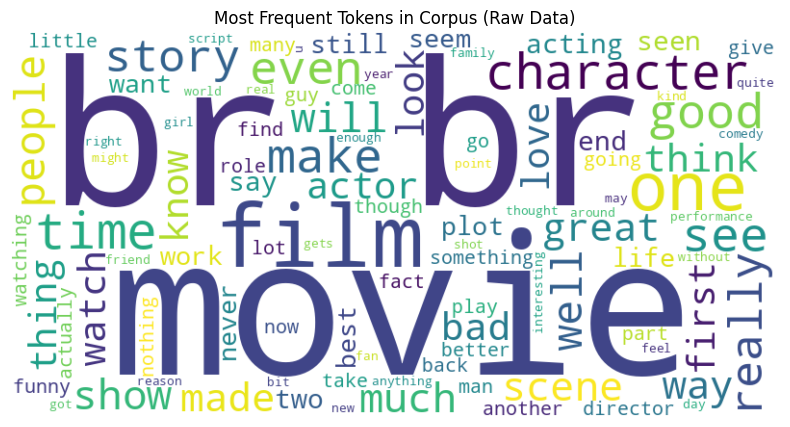

In [3]:
text_combined = " ".join(review for review in df.review)

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Tokens in Corpus (Raw Data)')
plt.show()

## 3. Text Processing Pipeline

Effective text classification requires normalization of input data. This process includes:

1.  **Tokenization:** Splitting the character stream into semantic units (words).
2.  **Lemmatization:** Reducing a word to its base dictionary form (e.g., *saw* $\rightarrow$ *see*, *movies* $\rightarrow$ *movie*). This is more advanced than stemming as it considers grammatical context.
3.  **Filtration:** Removing *stop words* (words with low information value, e.g., *the, is, at*) and punctuation.



In [4]:
def preprocess_text(text):
    """
    Executes the full text cleaning pipeline using spaCy.
    Args:
        text (str): Raw review text.
    Returns:
        str: Cleaned text consisting of lemmas.
    """
    # 1. Remove HTML tags (common artifact in IMDB)
    text = re.sub(r'<.*?>', ' ', text)

    # 2. Process via spaCy model
    doc = nlp(text)

    # 3. Extract lemmas for tokens that are not stop words, punctuation, or whitespace
    lemmas = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]

    return ' '.join(lemmas)

print("Starting pipeline processing (this may take a few moments)...")
# Apply function to the dataframe
df['clean_review'] = df['review'].apply(preprocess_text)
df[['review', 'clean_review']].head(3)

Starting pipeline processing (this may take a few moments)...


,review,clean_review
0,I really liked this Summerslam due to the look...,like summerslam look arena curtain look overal...
1,Not many television shows appeal to quite as m...,television show appeal different kind fan like...
2,The film quickly gets to a major chase scene w...,film quickly get major chase scene increase de...


## 4. Feature Extraction (Vectorization)

Machine Learning algorithms require numerical data representation. We will use the **TF-IDF** (Term Frequency-Inverse Document Frequency) method, which weights words based on their uniqueness across the corpus.

The formula for TF-IDF for term $t$ in document $d$ is:
$$ \text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t) $$
Where:
$$ \text{idf}(t) = \log \frac{N}{|\{d \in D : t \in d\}|} $$

To preserve context (e.g., negations like "not good"), we will employ **N-grams** (unigrams + bigrams).

In [5]:
# Vectorizer Configuration
# ngram_range=(1, 2): includes single words and word pairs
# max_features=5000: limits feature space to the 5000 most significant tokens
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

# Transform text corpus to sparse matrix
X = tfidf.fit_transform(df['clean_review'])
y = df['sentiment']

print(f"Feature Matrix X dimensions: {X.shape}")

Feature Matrix X dimensions: (2000, 5000)


## 5. Model Classification and Evaluation

We will use **Logistic Regression** as the baseline classifier. It is a linear model that performs well in high-dimensional NLP tasks and offers high result interpretability.

              precision    recall  f1-score   support

    negative       0.88      0.76      0.81       205
    positive       0.78      0.89      0.83       195

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



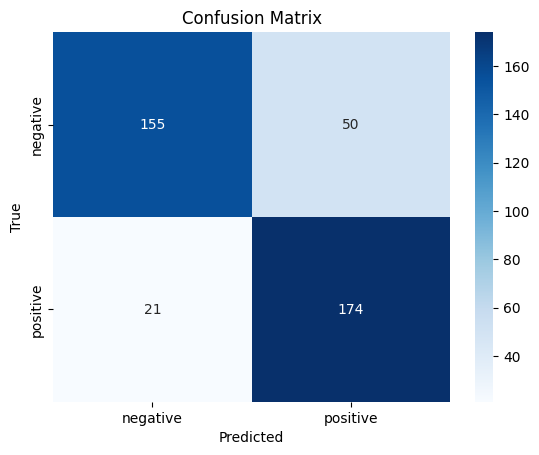

In [6]:
# Split into training and test sets (80/20)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df.index, test_size=0.2, random_state=42, stratify=y
)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Classification metrics
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 5.1 Model Interpretability (Feature Importance)
Analyzing the weights assigned by the model to specific features (words/bigrams) allows us to understand which phrases determine sentiment.

In [7]:
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_[0]
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefficients})

# Sort features and visualize the top features for both classes
top_positive = coef_df.sort_values(by='coef', ascending=False).head(10)
top_negative = coef_df.sort_values(by='coef', ascending=True).head(10)

print('Top positive features:')
print(top_positive)
print('Top negative features:')
print(top_negative)

Top positive features:
        feature      coef
1998      great  3.056139
2676       love  2.106839
1479  excellent  1.693488
209     amazing  1.539161
1411      enjoy  1.239352
415   beautiful  1.204743
1592   favorite  1.182017
1566     family  1.126497
3313    perfect  1.103580
1829        fun  1.044639
Top negative features:
       feature      coef
356        bad -4.926226
4839     waste -2.054088
346      awful -1.977411
4633       try -1.744760
3407      poor -1.549147
4443  terrible -1.542957
4297    stupid -1.526388
2888     money -1.469894
528     boring -1.465595
2925     movie -1.436016


## 6. Named Entity Recognition (NER)

**Named Entity Recognition** is the task of identifying and classifying named entities in text into predefined categories, such as persons (PERSON), organizations (ORG), or locations (GPE).

In the context of movie review analysis, NER allows for answering business questions, such as:
* Which actors or directors are discussed most frequently?
* Which studios appear in a negative context?

We will utilize the built-in `ner` component from spaCy.

Extracting PERSON entities from the entire dataset...


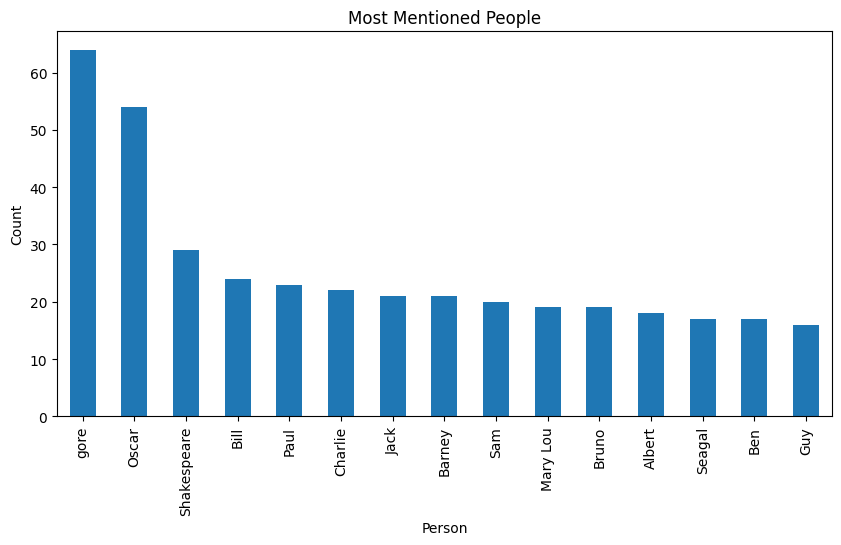

In [8]:
# Reload the model with the NER component enabled
# (We previously disabled it for preprocessing efficiency)
nlp_ner = spacy.load("en_core_web_sm")

def extract_entities(texts, label_filter=None):
    """
    Extracts named entities from a list of texts.
    Uses nlp.pipe for efficient batch processing.
    """
    entities = []
    # nlp.pipe processes texts as a stream - significantly faster than a for loop, batch size should be equal to 50
    for doc in nlp_ner.pipe(texts, batch_size=50):
        for ent in doc.ents:
            if label_filter is None or ent.label_ in label_filter:
                entities.append(ent.text)
    return entities

print("Extracting PERSON entities from the entire dataset...")
# Filter only persons (PERSON) - actors, directors, characters
people_entities = extract_entities(df['review'], label_filter=['PERSON'])

# Convert to DataFrame for easy analysis
people_df = pd.DataFrame(people_entities, columns=['Person'])
top_people = people_df['Person'].value_counts().head(15)

# Visuzalize most mmentioned people
top_people.plot(kind='bar', figsize=(10, 5))
plt.title('Most Mentioned People')
plt.ylabel('Count')
plt.show()

### Task 6.1: Cross-Analysis: Sentiment vs. Entities
Extract persons (`PERSON`) separately for positive and negative reviews to determine if specific names correlate with specific sentiments.

In [9]:
positive_reviews = df[df['sentiment'] == 'positive']['review']
negative_reviews = df[df['sentiment'] == 'negative']['review']

positive_people = extract_entities(positive_reviews, label_filter=['PERSON'])
negative_people = extract_entities(negative_reviews, label_filter=['PERSON'])

positive_counts = pd.Series(positive_people).value_counts().head(10)
negative_counts = pd.Series(negative_people).value_counts().head(10)

print('Top PERSON entities in positive reviews:')
print(positive_counts)
print('Top PERSON entities in negative reviews:')
print(negative_counts)

Top PERSON entities in positive reviews:
Oscar          39
gore           22
Shakespeare    20
Paul           19
Guy            15
Albert         15
Bill           14
Tony           13
Dieter         13
Powell         13
Name: count, dtype: int64
Top PERSON entities in negative reviews:
gore        42
Barney      21
Mary Lou    19
Sam         17
Oscar       15
Lee         15
Charlie     15
Jimi        14
Ben         13
Seagal      13
Name: count, dtype: int64
